# Introduction : Visualise attacks on a simple signal

## Signal generation

file saved


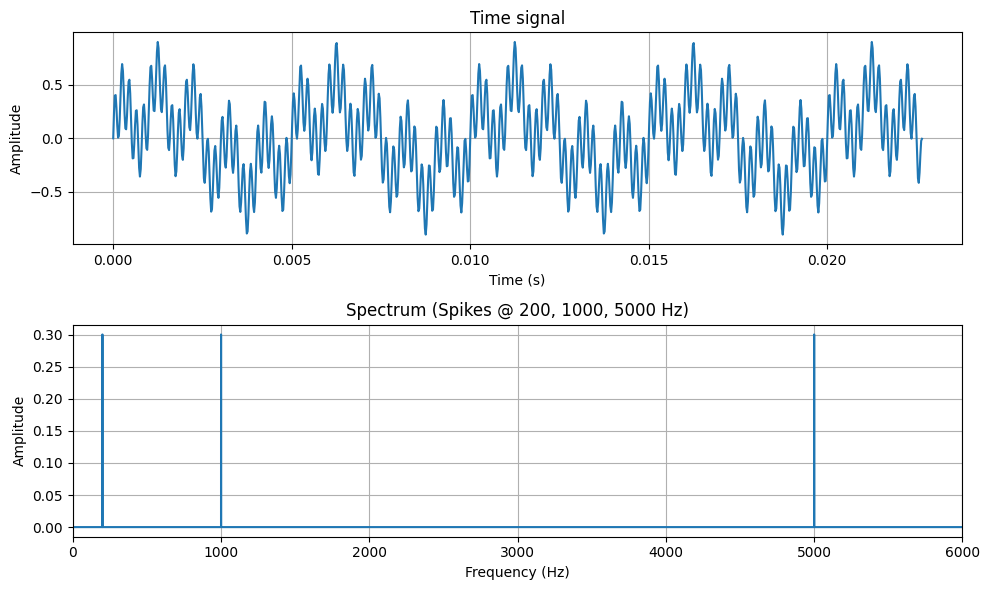

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Paramètres du signal
fs = 44100  # Fréquence d'échantillonnage (Hz)
duration = 5  # Durée (secondes)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Création du signal avec 3 composantes fréquentielles
f1, f2, f3 = 200, 1000, 5000  # Hz
signal = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t) + np.sin(2 * np.pi * f3 * t)

# Normalisation pour éviter la saturation
signal = signal / np.max(np.abs(signal)) * 0.9

# Sauvegarde en WAV (16 bits)
signal_int16 = (signal * 32767).astype(np.int16)
wavfile.write('signal.wav', fs, signal_int16)
print("file saved")

# Calcul du spectre (FFT)
fft_result = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), 1/fs)

mask = freqs >= 0
freqs_pos = freqs[mask]
magnitude = np.abs(fft_result[mask]) / len(signal) * 2

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(t[:1000], signal[:1000])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time signal')
axes[0].grid(True)

axes[1].plot(freqs_pos, magnitude)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Spectrum (Spikes @ {f1}, {f2}, {f3} Hz)')
axes[1].set_xlim(0, 6000)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Pitch Shift

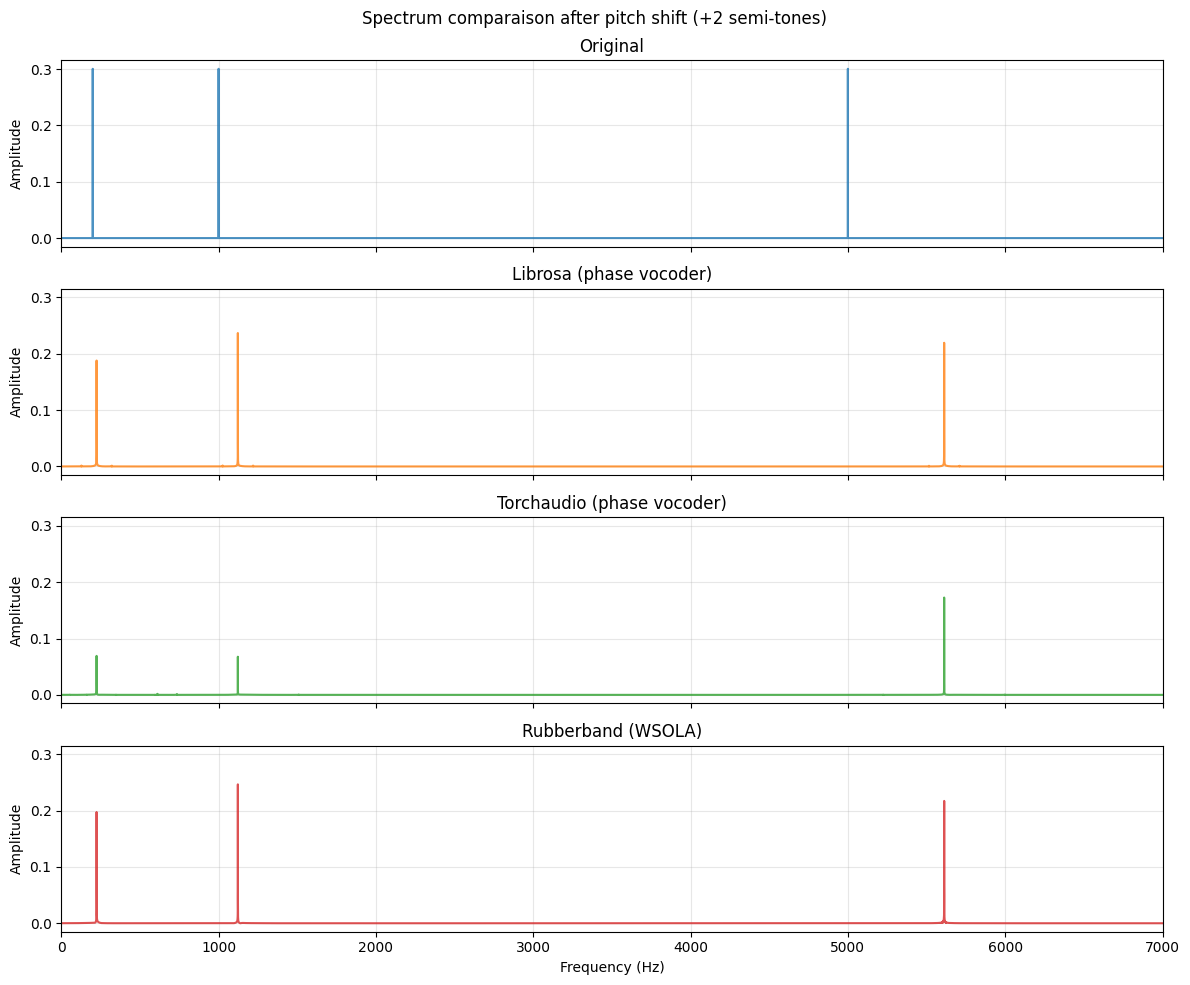

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torchaudio
import pyrubberband as pyrb

# --- Chargement du fichier WAV ---
input_file = 'signal.wav'  # <-- ton fichier ici
signal, fs = librosa.load(input_file, sr=None, mono=True)

# --- Paramètre de pitch shift ---
n_steps = 2  # +2 demi-tons

# --- Pitch shift avec différents algos ---
shifted_librosa = librosa.effects.pitch_shift(signal, sr=fs, n_steps=n_steps)

signal_tensor = torch.tensor(signal).unsqueeze(0).float()
shifted_torchaudio = torchaudio.functional.pitch_shift(signal_tensor, fs, n_steps).squeeze().numpy()

shifted_rubberband = pyrb.pitch_shift(signal, fs, n_steps)

# --- Calcul des spectres ---
def compute_spectrum(sig, fs):
    fft_result = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), 1/fs)
    mask = freqs >= 0
    return freqs[mask], np.abs(fft_result[mask]) / len(sig) * 2

freq_orig, mag_orig = compute_spectrum(signal, fs)
freq_lib, mag_lib = compute_spectrum(shifted_librosa, fs)
freq_torch, mag_torch = compute_spectrum(shifted_torchaudio, fs)
freq_rb, mag_rb = compute_spectrum(shifted_rubberband, fs)

# --- Visualisation en subplots alignés ---
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True, sharey=True)

data = [
    (freq_orig, mag_orig, 'Original', 'tab:blue'),
    (freq_lib, mag_lib, 'Librosa (phase vocoder)', 'tab:orange'),
    (freq_torch, mag_torch, 'Torchaudio (phase vocoder)', 'tab:green'),
    (freq_rb, mag_rb, 'Rubberband (WSOLA)', 'tab:red'),
]

for ax, (freqs, mag, label, color) in zip(axes, data):
    ax.plot(freqs, mag, color=color, alpha=0.8)
    ax.set_ylabel('Amplitude')
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 7000)

axes[-1].set_xlabel('Frequency (Hz)')
fig.suptitle(f'Spectrum comparaison after pitch shift (+{n_steps} semi-tones)', fontsize=12)
plt.tight_layout()

plt.savefig('comparaison_pitch_shift.png', dpi=150)
plt.show()

## Time Stretch

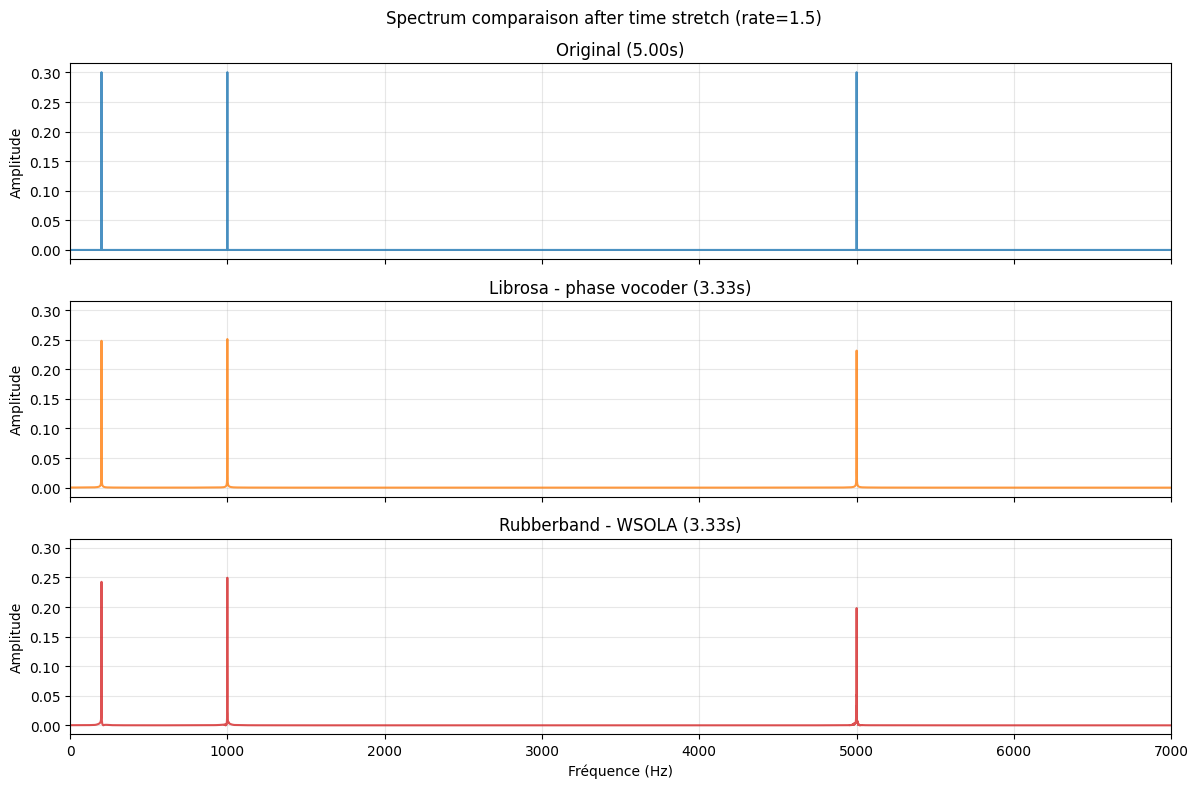

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pyrubberband as pyrb

# --- Chargement ---
input_file = 'signal.wav'
signal, fs = librosa.load(input_file, sr=None, mono=True)

# --- Paramètre de time stretch ---
rate = 1.5  # 1.5 = 50% plus rapide, 0.5 = 2x plus lent

# --- Time stretch avec différents algos ---
stretched_librosa = librosa.effects.time_stretch(signal, rate=rate)
stretched_rubberband = pyrb.time_stretch(signal, fs, rate)

# --- Calcul des spectres ---
def compute_spectrum(sig, fs):
    fft_result = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), 1/fs)
    mask = freqs >= 0
    return freqs[mask], np.abs(fft_result[mask]) / len(sig) * 2

freq_orig, mag_orig = compute_spectrum(signal, fs)
freq_lib, mag_lib = compute_spectrum(stretched_librosa, fs)
freq_rb, mag_rb = compute_spectrum(stretched_rubberband, fs)

# --- Visualisation ---
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)

data = [
    (freq_orig, mag_orig, f'Original ({len(signal)/fs:.2f}s)', 'tab:blue'),
    (freq_lib, mag_lib, f'Librosa - phase vocoder ({len(stretched_librosa)/fs:.2f}s)', 'tab:orange'),
    (freq_rb, mag_rb, f'Rubberband - WSOLA ({len(stretched_rubberband)/fs:.2f}s)', 'tab:red'),
]

for ax, (freqs, mag, label, color) in zip(axes, data):
    ax.plot(freqs, mag, color=color, alpha=0.8)
    ax.set_ylabel('Amplitude')
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 7000)

axes[-1].set_xlabel('Fréquence (Hz)')
fig.suptitle(f'Spectrum comparaison after time stretch (rate={rate})', fontsize=12)
plt.tight_layout()

plt.savefig('comparaison_time_stretch.png', dpi=150)
plt.show()

## Resampling

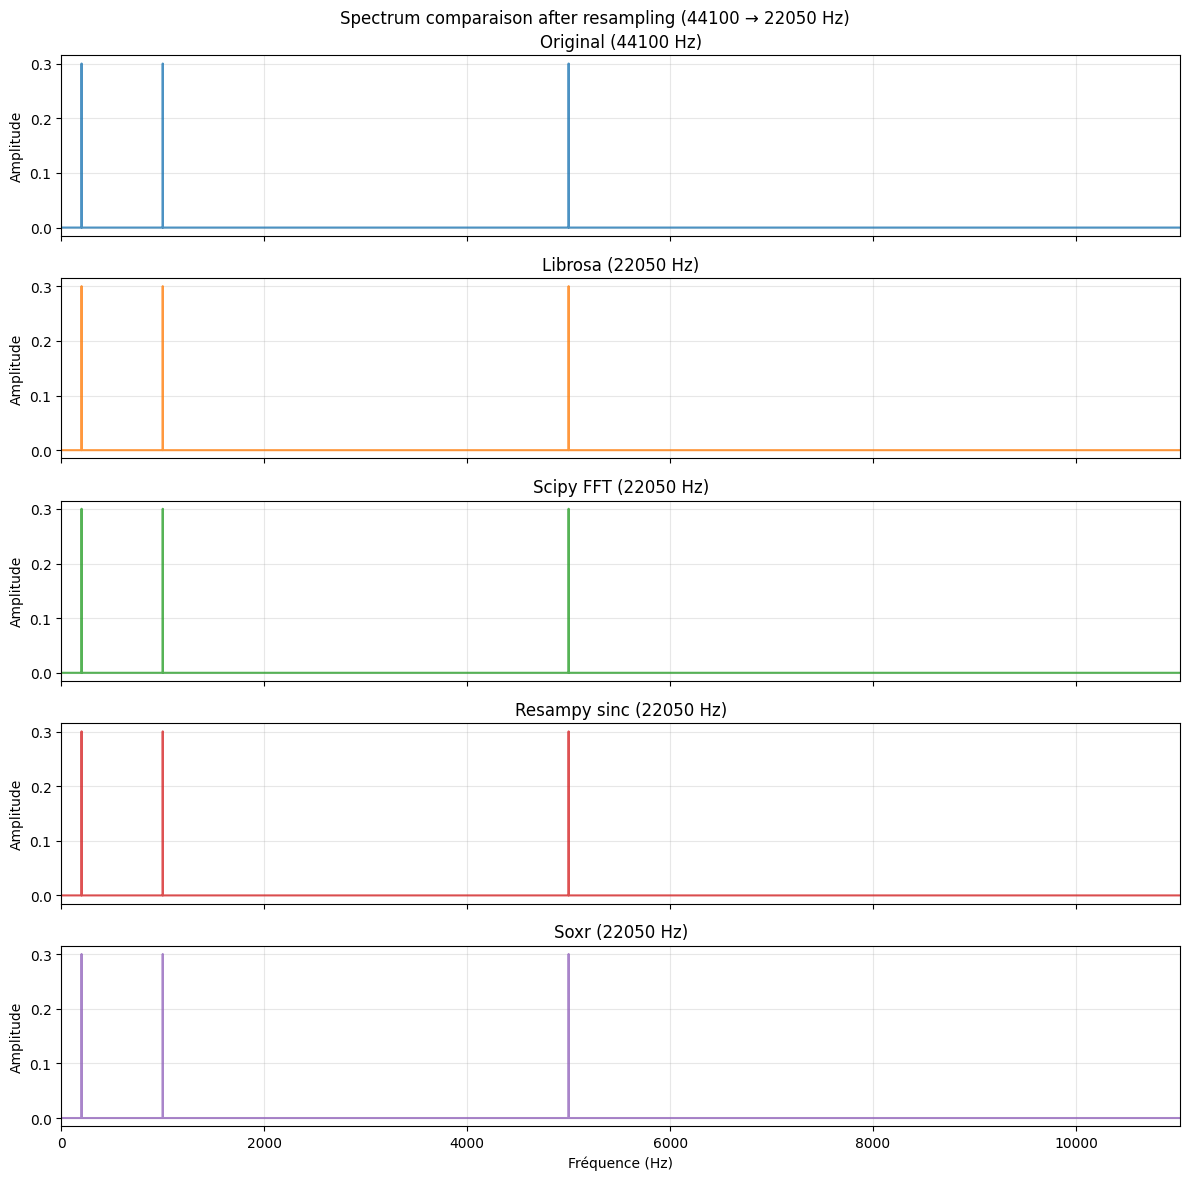

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal
import resampy
import soxr

# --- Chargement ---
input_file = 'signal.wav'
signal, fs = librosa.load(input_file, sr=None, mono=True)

# --- Paramètre de resampling ---
target_sr = 22050  # nouvelle fréquence cible

# --- Resampling avec différents algos ---
resampled_librosa = librosa.resample(signal, orig_sr=fs, target_sr=target_sr)
resampled_scipy = scipy.signal.resample(signal, int(len(signal) * target_sr / fs))
resampled_resampy = resampy.resample(signal, fs, target_sr)
resampled_soxr = soxr.resample(signal, fs, target_sr)

# --- Calcul des spectres ---
def compute_spectrum(sig, sr):
    fft_result = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), 1/sr)
    mask = freqs >= 0
    return freqs[mask], np.abs(fft_result[mask]) / len(sig) * 2

freq_orig, mag_orig = compute_spectrum(signal, fs)
freq_lib, mag_lib = compute_spectrum(resampled_librosa, target_sr)
freq_scipy, mag_scipy = compute_spectrum(resampled_scipy, target_sr)
freq_resampy, mag_resampy = compute_spectrum(resampled_resampy, target_sr)
freq_soxr, mag_soxr = compute_spectrum(resampled_soxr, target_sr)

# --- Visualisation ---
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True, sharey=True)

data = [
    (freq_orig, mag_orig, f'Original ({fs} Hz)', 'tab:blue'),
    (freq_lib, mag_lib, f'Librosa ({target_sr} Hz)', 'tab:orange'),
    (freq_scipy, mag_scipy, f'Scipy FFT ({target_sr} Hz)', 'tab:green'),
    (freq_resampy, mag_resampy, f'Resampy sinc ({target_sr} Hz)', 'tab:red'),
    (freq_soxr, mag_soxr, f'Soxr ({target_sr} Hz)', 'tab:purple'),
]

for ax, (freqs, mag, label, color) in zip(axes, data):
    ax.plot(freqs, mag, color=color, alpha=0.8)
    ax.set_ylabel('Amplitude')
    ax.set_title(label)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, min(fs, target_sr) / 2)  # Nyquist limit

axes[-1].set_xlabel('Fréquence (Hz)')
fig.suptitle(f'Spectrum comparaison after resampling ({fs} → {target_sr} Hz)', fontsize=12)
plt.tight_layout()

plt.savefig('comparaison_resampling.png', dpi=150)
plt.show()